# Import libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams
import re
from unidecode import unidecode
from tqdm import tqdm
import matplotlib.pyplot as plt

# Global variables

In [2]:
stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')
get_stem = False
# Change stopwords to upper
stopwords = [word.upper() for word in stopwords]

# Import offers

In [3]:
# df_offers = pd.read_json("./data/descripcion_ofertas_infojobs_21_23.json")
df_offers = pd.read_json("./data/descripcion_esco_infojobs_21_23.json")
df_offers.head()

,id_oferta,descripcion_oferta,id_puesto_esco_ull
0,ef5a8ae0a743018628df9bd53893bb,Empresa de carácter internacional solicita adm...,1634
1,47137c06a640348ca4cb7dcbf938b1,Las funciones a desempeñar son las propias del...,611
2,cdfb72672340819a6721db72eee187,Buscamos persona para puesto de Chófer -Repart...,2825
3,5746210e854264aaca9452f4d377a4,Abrimos proceso de selección para dependiente ...,1984
4,8a1bda0c91438bb4133f32e392a1ce,Tus funciones principales serán:\n\n- Atención...,1984


# Functions

In [22]:
def clean_text(text):
    # ! EXCEPCIONES MANUALES!!!
    # Cast exceptions to "a"
    text = re.sub(r'@', 'a', text)
    # Cast from "." to ""
    text = re.sub(r'\.', '', text)
    # Trim the text
    text = text.strip()
    # Remove accents using unidecode, excluding 'ñ' and 'Ñ'
    text = ''.join(char if char in ('ñ', 'Ñ') else unidecode(char) for char in text)
    # Delete non-alphanumeric characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Delete additional spaces with regex
    text = re.sub(r'\s+', ' ', text).upper()
    return text

def filter_words(text):
    # Split the text by " "
    list_words = text.split(" ")
    # Delete empty strings
    list_words = list(filter(None, list_words))
    # Filter all stopwords
    return [word for word in list_words if word not in stopwords]

def get_list_stems(list_words):
    # Get stems
    return [stemmer.stem(word).upper() for word in list_words]

def get_n_gramas(list_stems, min_n_gramas, max_n_gramas):
    list_n_gramas = [" ".join(n_grama) for n in range(min_n_gramas, max_n_gramas + 1)
                     for n_grama in ngrams(list_stems, n)]
    return list_n_gramas

def calculate_forms(text, min_n_gramas=2, max_n_gramas=4):
    # First clean text
    text = clean_text(text)
    # Filter words
    list_words = filter_words(text)
    # Get list of stems
    if get_stem:
        list_words = get_list_stems(list_words)
    # Get the n gramas
    list_n_gramas = get_n_gramas(list_words, min_n_gramas, max_n_gramas)
    if list_n_gramas != []:
        return list_n_gramas
    else:
        return None

def get_collocations(descripcion_oferta):
    # Get all forms from the description
    list_forms = calculate_forms(descripcion_oferta)
    return list_forms

def get_dictionary_collocations(df_test):
    n_gramas_finded = {}
    # Iterate over the rows of the dataframe with tqdm
    for index, row in tqdm(df_test.iterrows()):
        # Get the collocations of the description
        list_collocations = get_collocations(row['descripcion_oferta'])
        # If there are collocations
        if list_collocations is not None:
            # Iterate over the collocations
            for collocation in list_collocations:
                # If the collocation is in the dictionary
                if collocation in n_gramas_finded:
                    # Add one to the value
                    n_gramas_finded[collocation] += 1
                else:
                    # Add the collocation to the dictionary
                    n_gramas_finded[collocation] = 1
    # Cast to dataframe and reset the index
    n_gramas_finded_df = pd.DataFrame.from_dict(n_gramas_finded, orient='index', columns=['count']).reset_index()
    # Rename the columns
    n_gramas_finded_df.columns = ['COLLOCATIONS', 'COUNT']
    # Sort by COUNT
    n_gramas_finded_df.sort_values(by='COUNT', ascending=False, inplace=True)
    return n_gramas_finded_df.reset_index(drop=True)

def get_n_words(collocations):
    return len(collocations.split(" "))

def get_offers(df_offers, occupation = None):
    if occupation is not None:
        df_offers = df_offers[df_offers['id_puesto_esco_ull'] == occupation]
    return df_offers

# Main function

In [23]:
df_test = get_offers(df_offers, occupation=1508)
n_gramas_finded = get_dictionary_collocations(df_test)
n_gramas_finded.head()

4445it [00:05, 872.07it/s]


,COLLOCATIONS,COUNT
0,CARTERA CLIENTES,1193
1,FORMAR PARTE,870
2,PLAN CARRERA,850
3,DESARROLLO PROFESIONAL,800
4,SALARIO FIJO,722


# Split dataframe

In [8]:
def split_dataframe_by_n_words(n_gramas_finded):
    # Calculate the number of words for each collocation
    n_gramas_finded['N_WORDS'] = n_gramas_finded['COLLOCATIONS'].apply(get_n_words)
    # Calculate the unique values of n_words
    unique_n_words = n_gramas_finded['N_WORDS'].unique()
    # Create a dictionary to store DataFrames for each number of words
    collocations_by_n_words = {}
    # Separate the collocations by number of words
    for n_words in unique_n_words:
        # Filter the DataFrame for the current number of words
        collocations_by_n_words[n_words] = n_gramas_finded[n_gramas_finded['N_WORDS'] == n_words]
    return collocations_by_n_words, unique_n_words
collocations_by_n_words, unique_n_words = split_dataframe_by_n_words(n_gramas_finded)

# Visualize

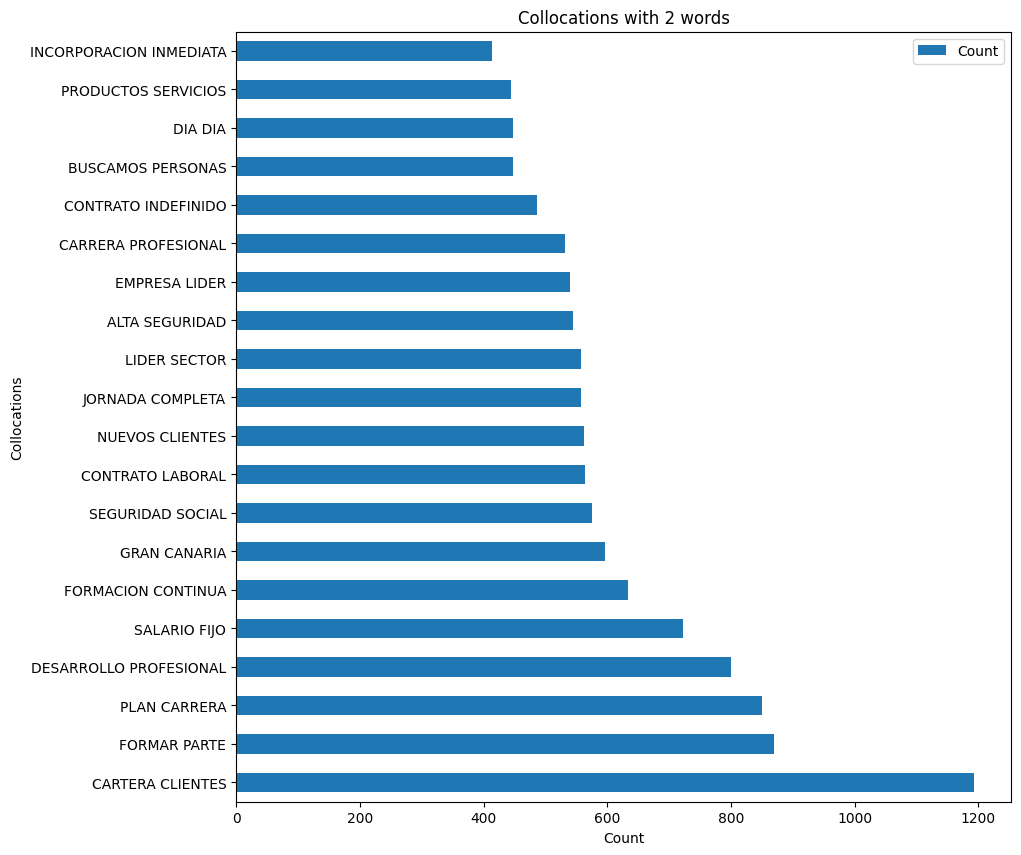

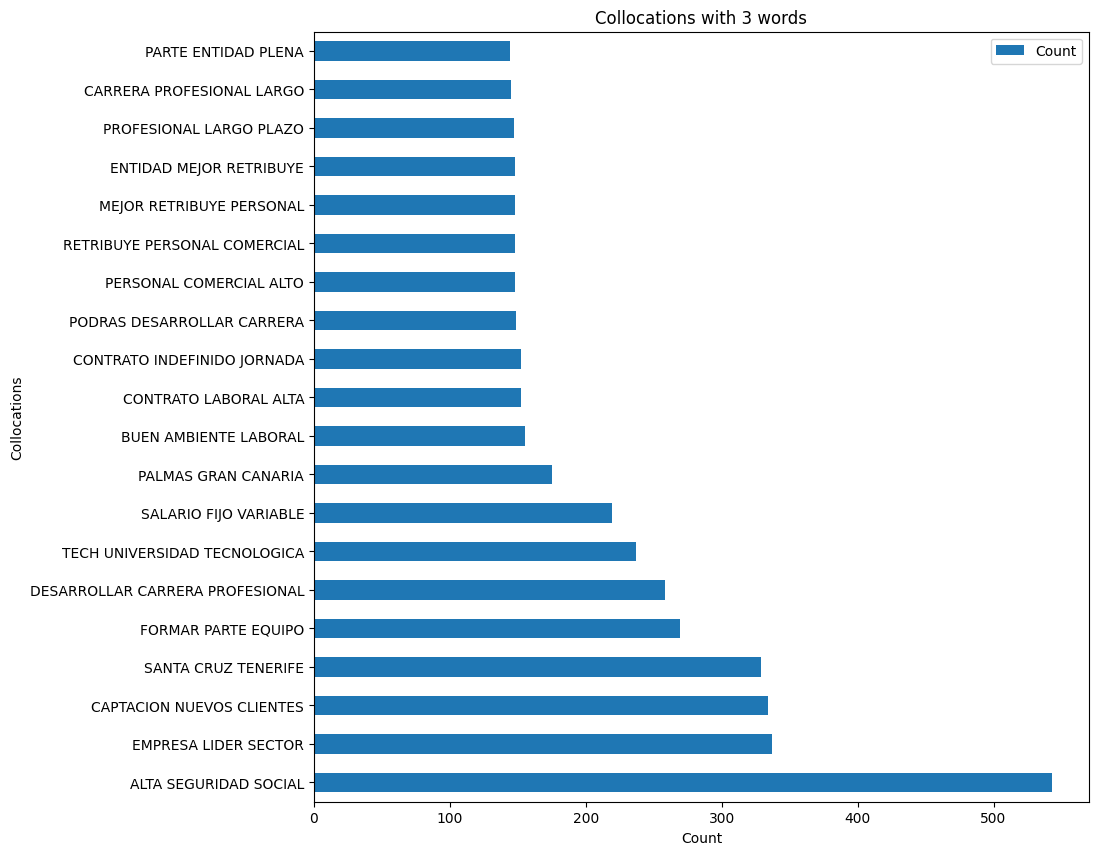

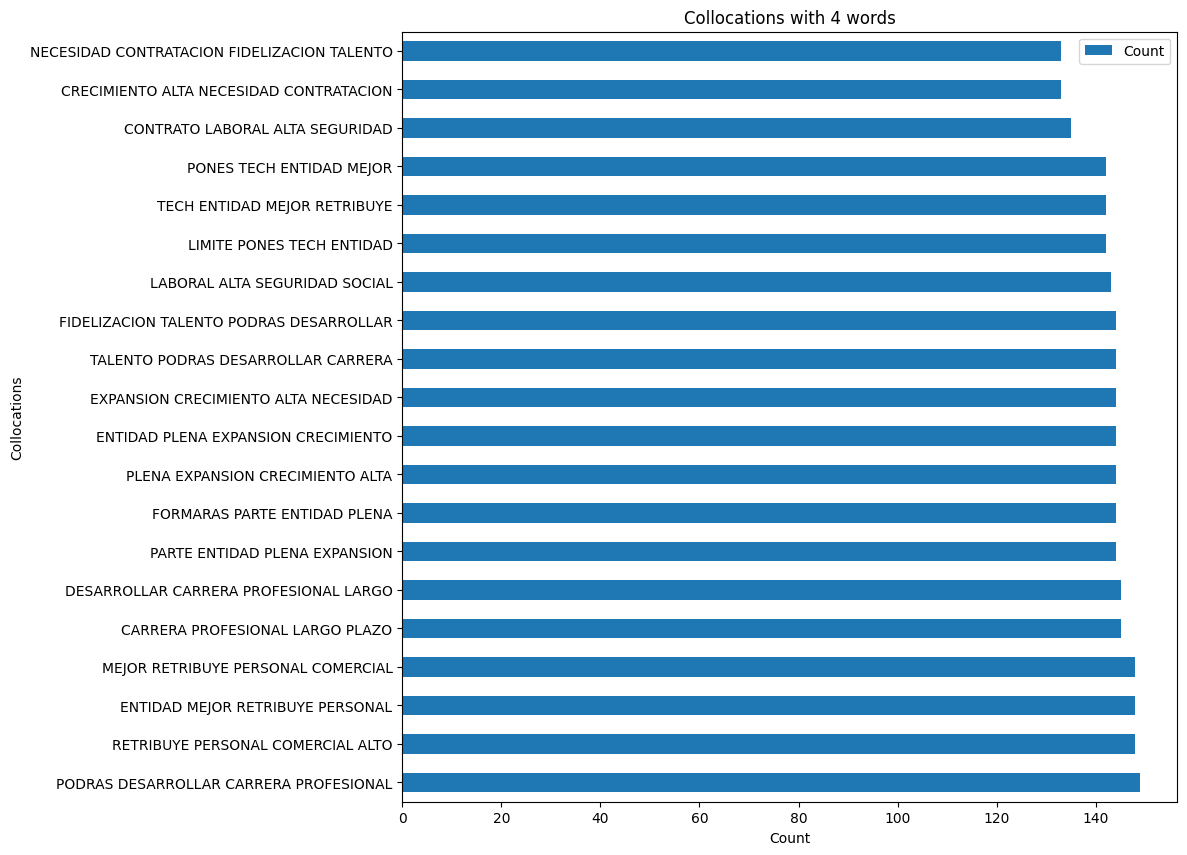

In [9]:
def visualize(collocations_by_n_words, unique_n_words):
    # Visualize each collocations_by_n_words in differents barplots
    for n_words in unique_n_words:
        # Get the current DataFrame
        df_current = collocations_by_n_words[n_words]
        # Get the first 20 collocations
        df_current = df_current.head(20)
        # Create the barplot
        ax = df_current.plot.barh(x='COLLOCATIONS', y='COUNT', figsize=(10, 10))
        # Set the title
        ax.set_title('Collocations with {} words'.format(n_words))
        # Set the x label
        ax.set_xlabel('Count')
        # Set the y label
        ax.set_ylabel('Collocations')
        # Set the legend
        ax.legend(['Count'])
        # Show the plot
        plt.show()
visualize(collocations_by_n_words, unique_n_words)

# New metric for characteristics

In [20]:
def get_collocations_metric_by_occupation(df_offers):
    # Get the n_gramas_finded for each id_puesto_esco_ull
    occupations = df_offers['id_puesto_esco_ull'].unique()
    n_gramas_finded_by_occupation = {}
    for occupation in occupations:
        # Get the offers for the current occupation
        df_offers_current = get_offers(df_offers, occupation=occupation)
        # Get the n_gramas_finded for the current occupation
        n_gramas_finded_by_occupation[occupation] = get_dictionary_collocations(df_offers_current)
    # Now get the dictionary_collocations for the full dataset
    n_gramas_finded_full = get_dictionary_collocations(df_offers)
    # Then divide the n_gramas_finded_full by the n_gramas_finded_by_occupation
    n_gramas_finded_by_occupation_normalized = {}
    for occupation in occupations:
        # Get the n_gramas_finded for the current occupation
        n_gramas_finded_current = n_gramas_finded_by_occupation[occupation]
        # Divide the count by the count of the full dataset if the collocation is in the full dataset
        n_gramas_finded_current['COUNT'] = n_gramas_finded_current.apply(lambda row: row['COUNT'] / n_gramas_finded_full[n_gramas_finded_full['COLLOCATIONS'] == row['COLLOCATIONS']]['COUNT'].values[0] if row['COLLOCATIONS'] in n_gramas_finded_full['COLLOCATIONS'].values else 0, axis=1)
        # Add the current n_gramas_finded to the dictionary
        n_gramas_finded_by_occupation_normalized[occupation] = n_gramas_finded_current
    return n_gramas_finded_by_occupation_normalized

n_gramas_finded_by_occupation_normalized = get_collocations_metric_by_occupation(df_offers)

KeyError: False